In [1]:
import scipy.io as io
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.optimize as opt

## 1、多分类

### 1.1 导入数据

In [30]:
data = io.loadmat('ex3data1.mat')
x = data['X']    # (5000, 400)
X = np.insert(x, 0, 1, axis=1)    # (5000, 401)
y = data['y']  # numpy直接把数据设置成uint8类型了,这是无符号的，不能取负数，所以你1-，或者取符号，它会下溢出，变成uint8能表达的最大正整数
y = y.astype(np.float) # (5000, 1)

### 1.2 可视化数据

In [71]:
def get_array(row):
    '''输入x的一行(400,)，输出20*20的数组，用于图片显示'''
    return row.reshape((20, 20)).T   # 不转置的话图片是歪的

def display_data(row, col):
    ''''输入行和列，显示图片'''
    pic_index = random.sample(range(x.shape[0]), row*col)
    pic_background = np.zeros((20*row, 20*col))
    for i in range(row):
        for j in range(col):
            pic_background[i*20: (i+1)*20, j*20: (j+1)*20] = get_array(x[pic_index[j+row*i]])
    plt.imshow(pic_background)

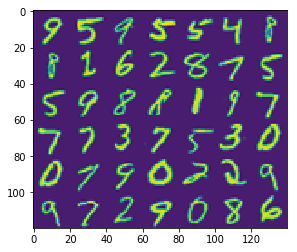

In [72]:
# 随机选取42个数据显示为6行7列
display_data(6, 7) 

### 1.3 求解假设函数

In [85]:
def h(theta, X):
    theta = theta.reshape(-1,1)
    '''假设函数'''
    return 1.0/(1+np.exp(-np.dot(X, theta)))

def j(theta, X, y):
    '''代价函数'''
    theta = theta.reshape(-1,1)
    # return -1/m * np.sum((y*np.log(h(theta, X)) + (1-y)*np.log(1-h(theta, X)))) # RuntimeWarning: divide by zero encountered in log
    return -1/m * np.sum((y*np.log(h(theta, X)+1e-5) + (1-y)*np.log(1-h(theta, X)+1e-5)))# 不加的时候会有0

def gradient(theta, X, y):
    theta = theta.reshape(-1,1)
    grid = 1/m * np.dot(X.T, h(theta, X)-y)
    return grid.reshape(-1)

### 1.4 二分类的情况 

In [75]:
m = X.shape[0]
theta = np.zeros(401)

import scipy.optimize as opt
y1 = np.where(y==1, 1, 0)
result = opt.fmin_tnc(func=j, x0=theta, args=(X, y1), fprime=gradient)
h(result[0], X)    # (5000, 1)

array([[1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       ...,
       [6.61291012e-73],
       [5.04333681e-57],
       [8.73780493e-19]])

### 1.5 多分类的情况

In [87]:
m = X.shape[0]
theta = np.zeros(401)

# 10个分类器对应10个theta，同时对应10个h(5000,1)。h_multi一共10列，每列都是h。
h_multi = np.empty([5000, 10])
for i in range(1,11):
    result = opt.fmin_tnc(func=j, x0=theta, args=(X, np.where(y==i, 1, 0)), fprime=gradient)
    h_multi[:, i-1] = h(result[0], X).reshape(-1) # (5000, 1)

h_multi.shape

c:\users\10064\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


(5000, 10)

In [83]:
# h_multi=[h1(y=1的h),h2,h3,...,h10]，分别对应0,1,2,,,,,9列
y_pred = np.argmax(h_multi,axis=1) + 1 # 计算每一行最大值对应索引
np.sum(y_pred == y.reshape(-1))/5000

0.9894

## 2、前向传播

### 2.1 导入数据

In [3]:
data = io.loadmat('ex3data1.mat')
x = data['X']    # (5000, 400)
X = np.insert(x, 0, 1, axis=1)    # (5000, 401)
y = data['y']  # numpy直接把数据设置成uint8类型了,这是无符号的，不能取负数，所以你1-，或者取符号，它会下溢出，变成uint8能表达的最大正整数
y = y.astype(np.float) # (5000, 1)

wights = io.loadmat('ex3weights')
theta1 = wights['Theta1'] # (25, 401)
theta2 = wights['Theta2'] # (10, 26)

### 2.2 向量化前向传播

In [9]:
def g(z):
    return 1/(1+np.exp(-z))

def propagate_forward(a1, theta):
    a1 = np.insert(a1, 0, 1, 1)
    z2 = np.dot(a1, theta.T)
    a2 = g(z2)
    return a2    

In [12]:
# 向量化前向传播
a2 = propagate_forward(x, theta1) # (5000, 25)
a3 = propagate_forward(a2, theta2) # (5000, 10)

### 2.3 模型预测并计算准确率

In [21]:
# 模型预测
y_pred = np.argmax(a3, axis=1) + 1

In [22]:
# 计算准确率
np.sum(y_pred == y.reshape(-1))/5000

0.9752

### 2.4 显示预测错误的图片

In [65]:
# 预测错误图片的索引及其对应的x，y
wrong_index = y_pred != y.reshape(-1)   # (5000, )
wrong_x = x[wrong_index] # (124, 400)
wrong_pred = y_pred[wrong_index].reshape(-1,1) # (124,1)
right_y = y[wrong_index] # (124,1)

In [90]:
def display_1_pic(k):
    '''输入数字，显示对应预测错误的图片'''
    pic_array = wrong_x[k].reshape((20, 20)).T   # 第k个预测错误的图片对应的array
    plt.imshow(pic_array)

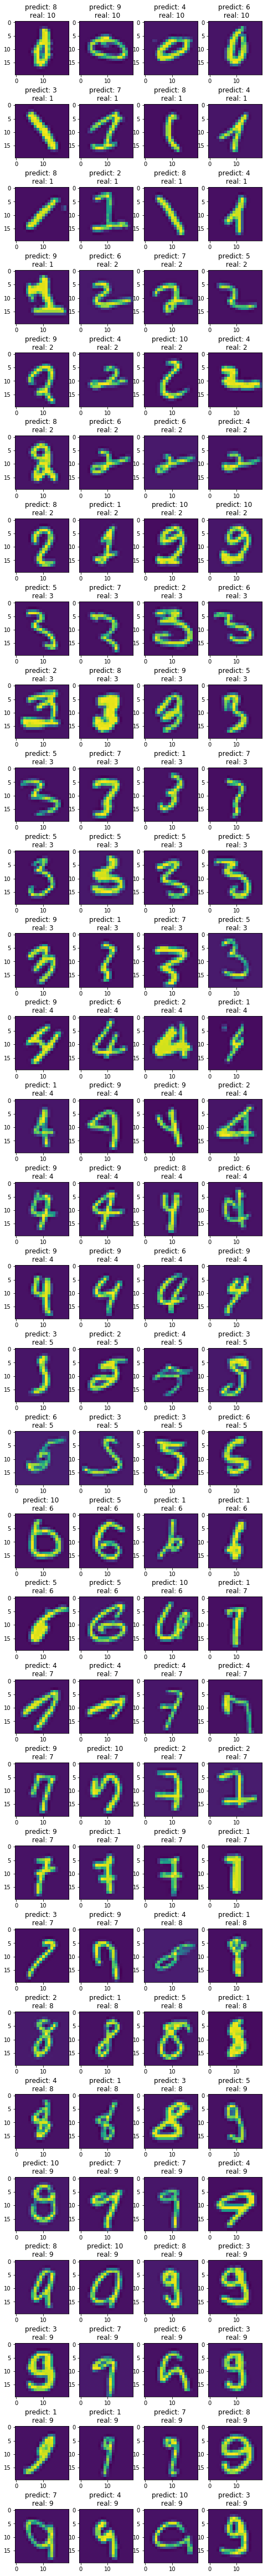

In [92]:
plt.figure(figsize=(8, 85)) # 表示figure 的大小为宽、长（单位为inch）
for i in range(1, 125):
    plt.subplot(31, 4, i)
    display_1_pic(i-1)
    plt.title('predict: %d \n real: %d' % (wrong_pred[i-1], right_y[i-1]))
    # plt.tight_layout() # 调整图片之间距离